# AI vs Human Text Classification using Machine Learning

This notebook demonstrates the process of processing texts into machine-readable data and feeding it into 3 different models to train them before reviewing their performance. The 3 models are: Support Vector Machine (SVM), Decision Tree, and AdaBoost.

## Import Libraries

In [1]:
# Misc imports
from os import path  # cross-platform file path handling
import time          # measure training and testing time

# Data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Text processing
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string

# Machine learning
from sklearn.model_selection import ( train_test_split, GridSearchCV, cross_val_score, StratifiedKFold )
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ( accuracy_score, classification_report, confusion_matrix, f1_score,
        roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, PrecisionRecallDisplay )

import joblib

# Download necessary NLTK resources for text processing
nltk.download("wordnet") # WordNet for lemmatization
nltk.download("punkt") # Tokenizer
nltk.download("punkt_tab")
nltk.download("stopwords") # Stopwords for text cleaning
nltk.download("averaged_perceptron_tagger") # POS tagger for part-of-speech tagging
nltk.download("averaged_perceptron_tagger_eng") # Additional tagger for English

[nltk_data] Downloading package wordnet to /home/sang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/sang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/sang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/sang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

## Set Global Variables

In [2]:
# Data Path Variables
DATA_PATH = path.join("..", "data")
TRAIN_CSV = path.join(DATA_PATH, "AI_vs_huam_train_dataset.csv")

# Model Path Variables
MODELS_PATH = path.join("..", "models")

---

## 1. Data Analysis & Preprocessing

### 1.1. Data Analysis

In [3]:
# Load the training data for analysis
df_train = pd.read_csv(TRAIN_CSV)

# Describe statistics of the data
df_train.describe()

,label
count,3728.000000
mean,0.500000
std,0.500067
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [4]:
# Print first 5 samples
df_train.head()

,essay,label
0,International sports events require the most w...,0
1,Globalisation has become a significant aspect ...,0
2,There is an ever-increasing number of bullying...,0
3,"It is commonly believed, that companies should...",0
4,Despite knowing about the adverse effects of c...,0


In [5]:
# Print last 5 samples
df_train.tail()

,essay,label
3723,I agree that successful people are willing to ...,1
3724,I believe that people who are open to trying n...,1
3725,"To succeed in life, we must do everything poss...",1
3726,"I'm not entirely sure what the word ""successfu...",1
3727,The key to success is trying new things while ...,1


### 1.2. Preprocessing

#### 1.2.1. Preprocessing Functions

In [6]:
# Create the lemmatizer object for lemmatization
lemmatizer = WordNetLemmatizer()

# Compile regex objects to remove non-latin characters
single_quote_expr = re.compile(r'[\u2018\u2019]', re.U)
unicode_chars_expr = re.compile(r'[\u0080-\uffff]', re.U)

Define a set of preprocessing functions and `preprocess_text()` function to chain the together in one function

In [7]:
def get_pos_tag(token):
    """
        Return the POS tag associated with the token
    """
    tag_dict = {
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "A": wordnet.ADJ,
        "R": wordnet.ADV
    }

    tag = nltk.pos_tag([token])[0][1][0]
    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize_text(text):
    """
        Converts text to lemmatized version to prepare it for vectorization
    """
    
    tokens = word_tokenize(text)

    lemma_tokens = []
    for token in tokens:
        pos_tag = get_pos_tag(token)
        lemma_tokens.append(lemmatizer.lemmatize(token, pos_tag))

    return " ".join(lemma_tokens)
        


def clean_text(text):
    """
        Convert text to lowercase, removes punctuations and special characters
    """
    
    # Return empty string if text is not a string
    if not isinstance(text, str):
        return ""
    
    # Remove non-latin characters
    tmp = single_quote_expr.sub("'", text, re.U)
    tmp = unicode_chars_expr.sub("", tmp, re.U)

    # Convert text to lowercase
    tmp = tmp.lower()

    # Remove numbers, decimals, and mixed words
    # Also strips the text of leading whitespaces
    # i.e. 123, 12.345, mi123x, 123mix, mix123
    tmp = " ".join([
        word for word in tmp.strip().split() if not re.match(r"(\d+.*|\w+(\d+.*)+)", word)
    ])

    # Remove punctuations and special characters
    tmp = re.sub(rf"[{ string.punctuation }]", "", tmp)

    # Remove stopwords
    #STOPWORDS = stopwords.words("english")
    stop_words = stopwords.words("english")
    return " ".join([
        word for word in tmp.split() if not word in stop_words
    ])

def preprocess_text(text):
    cleaned = clean_text(text)
    return lemmatize_text(cleaned)

#### 1.2.2. Apply Preprocessing

This section will apply the a chain of preprocessing functions starting with `preprocess_text()` to the `"essay"` column acting as the training input.

In [8]:
# Apply text preprocessing and stored processed text into a different column
df_train["processed"] = df_train["essay"].apply(preprocess_text)

In [9]:
# Print a sample of unprocessed and processed essay text for demonstration
print("-- Original --:", df_train["essay"][0], end="\n\n")
print("-- Processed --:", df_train["processed"][0])

-- Original --: International sports events require the most well-trained athletes for each country, in order to achieve this goal countries make an effort to build infrastructure designed to train top athletes. Although this policy can indeed make fewer sports facilities for ordinary people, investing in the best athletes is vital to develop competitive sports performances in each country.
On the one hand, building specific infrastructure for the best athletes is crucial in order to get better results at international sports events such as The Olympics or the World Cup. The importance of getting better results is that it creates awareness of the importance of sports in society and motivates more people to do a sport. In this way, investing in these developments can help countries to develop an integral sport policy that can benefit everyone.
On the other hand, one can argue that a negative effect could be that less infrastructure is built for the rest of the people. However, people wh

#### 1.2.3. Prepare Data for Feature Extraction

In [10]:
# Determine the input and output of the data
X = df_train["processed"]
y = df_train["label"]

# Split the data into training and testing datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### 1.3. Feature Extraction through Vectorization

In [11]:
# Set up TfidfVectorizer to vectorize the processed text for feature extraction
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    max_df=0.95,
    min_df=2,
    max_features=1000,
)

In [12]:
# Vectorizer the inputs into machine-readable data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

## 2. Model Development & Optimization

### 2.1. Model Development

In [13]:
# Create a class to easily handle the many tasks related to training and testing models
class Model:
    def __init__(self, model_name, model, params):
        self.name = model_name
        self.model = model
        self.params = params
        self.gs = None
        self.duration = None
        self.results = None

    
    def grid_search(self, print_time=True):
        """
            Create a GridSearchCV and hypertune parameters
        """
        
        self.gs = GridSearchCV(
            self.model(random_state=42),
            self.params,
            scoring="accuracy",
            n_jobs=6,
        )
        
        start_time = time.time()

        self.gs.fit(X_train_tfidf, y_train)

        self.results = self.gs
        self.duration = time.time() - start_time

        if print_time:
            print(f"GridSearch took {self.duration:.4f} seconds.")
            print(f"Best parameters:\n\t\t{self.gs.best_params_}")
            print(f"Best score:\n\t\t{self.gs.best_score_:.4f}")

    def save_model(self):
        """
            Save either the GridSearchCV's model with tuned parameters or regular model
            if the former doesn't exist
        """

        file_name = f"model_{ re.sub(r"\s", "_", self.name) }.pkl"
        
        with open(path.join(MODELS_PATH, file_name), "wb") as file:
            if self.gs is None:
                joblib.dump(self.model, file)
            else:
                joblib.dump(self.gs.best_estimator_, file)
            
    ######################################################
    #################### Statistics ######################
    ######################################################
    
    def update_stat(self, new_y_val, new_y_score):
        """
            Create scores and store them in the class
        """
        self.y_true = new_y_val
        self.y_pred = new_y_score
        self.accuracy = accuracy_score(new_y_val, new_y_score)
        self.precision = precision_score(new_y_val, new_y_score)
        self.recall = recall_score(new_y_val, new_y_score)
        self.f1_macro = f1_score(new_y_val, new_y_score, average="macro")
        self.f1_weighted = f1_score(new_y_val, new_y_score, average="weighted")
        self.confusion_matrix = confusion_matrix(new_y_val, new_y_score)
        self.roc_auc_score = roc_auc_score(new_y_val, new_y_score)


    def print_stat(self):
        """
            Print the scores, confusion matrix, and classification report
        """
        print(f"Accuracy Score:\t\t{self.accuracy*100:.2f}%")
        print(f"Precision Score:\t{self.precision*100:.2f}%")
        print(f"Recall Score:\t\t{self.recall*100:.2f}%")
        print(f"F1-score (macro):\t{self.f1_macro*100:.2f}%")
        print(f"F1-score (weighted):\t{self.f1_weighted*100:.2f}%")
        print(f"ROC AUC Score:\t\t{self.roc_auc_score*100:.2f}%")
        print("Confusion Matrix:\n", self.confusion_matrix)
        print(classification_report(self.y_true, self.y_pred, target_names=["Human", "AI"]))


    def plot_roc_curve(self):
        # Calculate ROC curve and ROC AUC
        fpr, tpr, thresholds = roc_curve(self.y_true, self.y_pred)
    
        # Plot the ROC curve
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (area = {self.roc_auc_score:.2f}")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for {self.name}")
        plt.legend()
        plt.show()

    
    def plot_precision_recall(self):
        PrecisionRecallDisplay.from_predictions(self.y_true, self.y_pred)
        plt.title(f"Precision-Recall Curve for {self.name}")
        plt.show()

    
    def create_row(self):
        """
            Creates a row to be used in a comparison table
        """
        return [self.name, self.accuracy, self.precision, self.recall,
                   self.f1_macro, self.f1_weighted, self.roc_auc_score]

    
    def create_comparison_table(self, other_stat):
        data = [self.create_row(), other_stat.create_row()]

        return pd.DataFrame(data, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score (macro)", "F1-score (weighted)", "ROC AUC Score"])

#### 2.1.1. Set up the Models for Optimization

In [14]:
# Support Vector Machine (SVM)
svm = Model("Support Vector Machine", SVC, {
    "C": [0.05, 0.01, 10, 100],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto", 0.001, 0.01]
})

In [15]:
# Decision Tree
dt = Model("Decision Tree", DecisionTreeClassifier, {
    "criterion": ["gini", "entropy"],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
})

In [16]:
# AdaBoost
ada = Model("AdaBoost", AdaBoostClassifier, {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.5, 1.0, 1.5]
})

### 2.2. Optimization

Hyperparameterize all of the 3 models to get the best models with their best parameters

In [17]:
# SVM
svm.grid_search()

GridSearch took 91.6213 seconds.
Best parameters:
		{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best score:
		0.9688


In [18]:
# Decision Tree
dt.grid_search()

GridSearch took 20.2895 seconds.
Best parameters:
		{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best score:
		0.8602


In [19]:
# AdaBoost
ada.grid_search()

GridSearch took 33.9477 seconds.
Best parameters:
		{'learning_rate': 1.0, 'n_estimators': 200}
Best score:
		0.9571


### 2.2.1. Evaluate with Testing Data

In [20]:
# Store the predictions for each models
y_pred_svm = svm.gs.best_estimator_.predict(X_val_tfidf)
y_pred_dt = dt.gs.best_estimator_.predict(X_val_tfidf)
y_pred_ada = ada.gs.best_estimator_.predict(X_val_tfidf)

In [21]:
# Update the accuracy metrics for each models
svm.update_stat(y_val, y_pred_svm)
dt.update_stat(y_val, y_pred_dt)
ada.update_stat(y_val, y_pred_ada)

## 3. Performance Evaluation & Analysis

### 3.1. Performance Evaluation

#### 3.1. Accuracy Metrics

In [22]:
svm.print_stat()

Accuracy Score:		96.65%
Precision Score:	95.56%
Recall Score:		97.45%
F1-score (macro):	96.64%
F1-score (weighted):	96.65%
ROC AUC Score:		96.69%
Confusion Matrix:
 [[377  16]
 [  9 344]]
              precision    recall  f1-score   support

       Human       0.98      0.96      0.97       393
          AI       0.96      0.97      0.96       353

    accuracy                           0.97       746
   macro avg       0.97      0.97      0.97       746
weighted avg       0.97      0.97      0.97       746



In [23]:
dt.print_stat()

Accuracy Score:		84.72%
Precision Score:	83.29%
Recall Score:		84.70%
F1-score (macro):	84.69%
F1-score (weighted):	84.72%
ROC AUC Score:		84.72%
Confusion Matrix:
 [[333  60]
 [ 54 299]]
              precision    recall  f1-score   support

       Human       0.86      0.85      0.85       393
          AI       0.83      0.85      0.84       353

    accuracy                           0.85       746
   macro avg       0.85      0.85      0.85       746
weighted avg       0.85      0.85      0.85       746



In [24]:
ada.print_stat()

Accuracy Score:		96.65%
Precision Score:	96.33%
Recall Score:		96.60%
F1-score (macro):	96.64%
F1-score (weighted):	96.65%
ROC AUC Score:		96.65%
Confusion Matrix:
 [[380  13]
 [ 12 341]]
              precision    recall  f1-score   support

       Human       0.97      0.97      0.97       393
          AI       0.96      0.97      0.96       353

    accuracy                           0.97       746
   macro avg       0.97      0.97      0.97       746
weighted avg       0.97      0.97      0.97       746



#### 3.2 ROC Curve

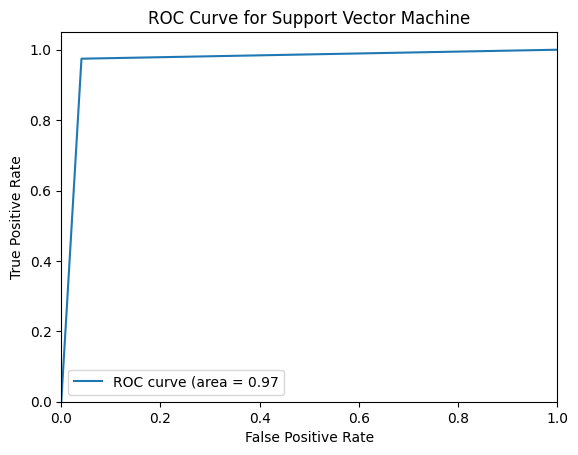

In [25]:
svm.plot_roc_curve()

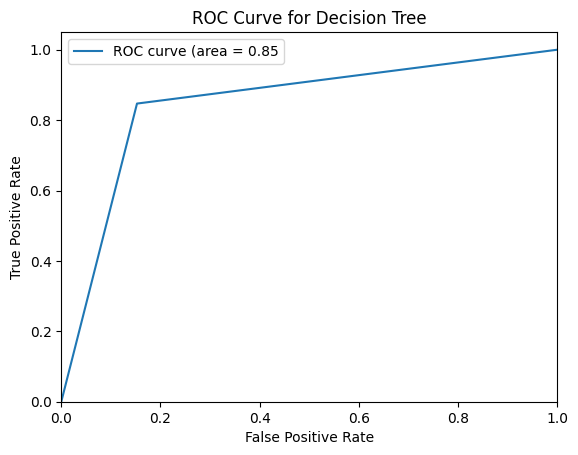

In [26]:
dt.plot_roc_curve()

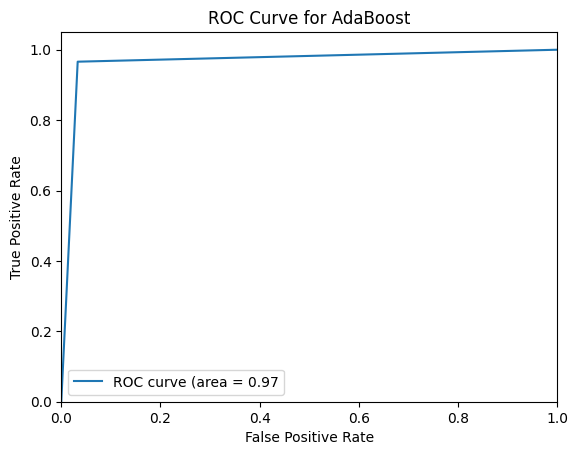

In [27]:
ada.plot_roc_curve()

#### 3.3 Precision-Recal Curve

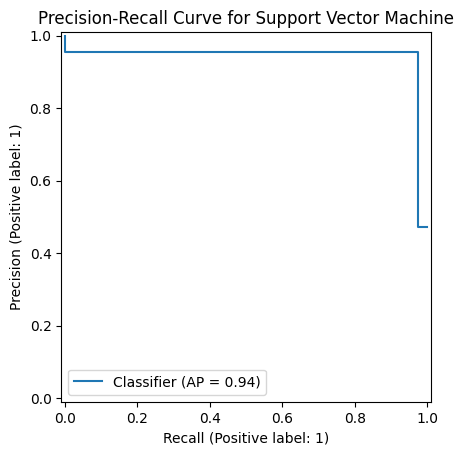

In [28]:
svm.plot_precision_recall()

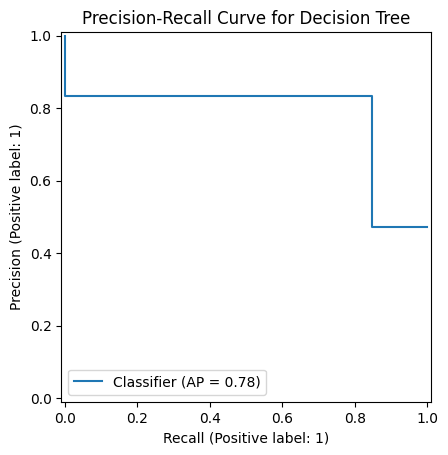

In [29]:
dt.plot_precision_recall()

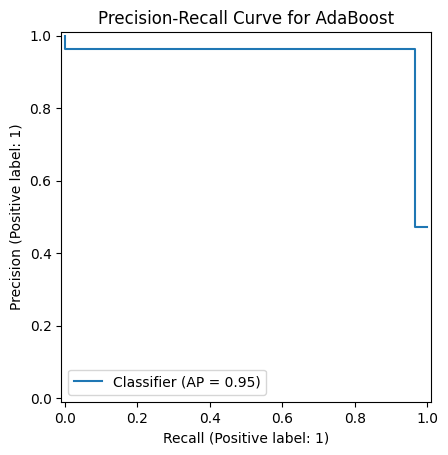

In [30]:
ada.plot_precision_recall()

### 3.2. Analysis

Based on the accuracy metrics, precision-recall curve, and ROC AUC curve, Decision Tree performs worse than both Support Vector Machine (SVM) and AdaBoost. In comparison, both SVM and AdaBoost models have the same over performance with slight differences in varying accuracy metrics. Based on both of the models' precision and recall scores, SVM performs better than AdaBoost and, as such, is the best model to classify texts as AI or human-written over the other two.

---

## Saving the Models

In [32]:
# Save the optimized models
svm.save_model()
dt.save_model()
ada.save_model()

In [33]:
# Also save the associated TfidfVectorizer to be used in the Streamlit app
with open(path.join(MODELS_PATH, "tfidf_vectorizer.pkl"), "wb") as file:
    joblib.dump(vectorizer, file)